In [1]:
import pandas as pd
import numpy as np
import pickle
from scipy.stats import zscore
import seaborn as sns
import matplotlib.pyplot as plt
from msresist.pre_processing import preprocessing, filter_NaNpeptides, MeanCenter, Log2T
from msresist.clustering import MassSpecClustering
from msresist.figures.figureM1 import TumorType
from msresist.figures.figure1 import pca_dfs, plotClustergram
from msresist.figures.figure3 import plotPCA, plotClusters


sns.set(style="whitegrid", font_scale=1.2, color_codes=True, palette="colorblind", rc={"grid.linestyle": "dotted", "axes.linewidth": 0.6})

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
# pd.set_option('display.max_colwidth', 1000)
# pd.set_option('display.max_rows', 1000000)
# pd.set_option('display.max_columns', 1000)

## Import and Preprocess Data

In [4]:
# X = preprocessing(CPTAC=True, log2T=True)
X = pd.read_csv("msresist/data/MS/CPTAC/CPTAC-preprocessedMotfis.csv").iloc[:, 1:]

d = X.select_dtypes(include=['float64']).T
i = X.select_dtypes(include=['object'])

In [5]:
X.head()

Sequence         Protein     Gene Position  C3N.01799  C3N.01799.N  \
0  AAAAAsGGGVS     NP_002577.2     PBX2   S146-p        NaN          NaN   
1  AAAAAsQQGSA  NP_001308122.1  TBL1XR1   S119-p        NaN          NaN   
2  AAAAAsTQAQQ  NP_001035540.1   MINDY2   S575-p   0.012034    -0.630863   
3  AAAAGsASPRS     NP_064520.2   WRNIP1   S151-p        NaN          NaN   
4  AAAAGsGPSPP     NP_060895.1   PI4K2A    S44-p        NaN          NaN   

   C3L.01890  C3L.01890.N  C3N.00572  C3N.00572.N  C3N.02423  C3N.02423.N  \
0        NaN          NaN        NaN          NaN        NaN          NaN   
1        NaN          NaN        NaN          NaN        NaN          NaN   
2  -1.159479    -0.740044   0.107228    -0.016971  -0.023379    -0.481045   
3        NaN          NaN        NaN          NaN        NaN          NaN   
4        NaN          NaN        NaN          NaN        NaN          NaN   

   C3N.02729  C3N.02729.N  C3L.00263  ...  C3N.00738  C3N.00738.N  C3N.00959  \
0        NaN          NaN        NaN  ...        NaN          NaN        NaN   
1        NaN          NaN        NaN  ...   0.071547    -0.600298   0.172339   
2        NaN          NaN        NaN  ...        NaN          NaN        NaN   
3        NaN          NaN        NaN  ...        NaN          NaN        NaN   
4    0.83783    -0.993838   0.317079  ...   0.031572    -0.554645  -0.033640   

   C3N.00959.N  C3N.02003  C3N.02003.N  C3N.02379.N  C3N.00175  C3N.00175.N  \
0          NaN        NaN          NaN          NaN        NaN          NaN   
1    -1.761406   0.421872    -0.372907    -0.979491  -0.083036    -0.361962   
2          NaN        NaN          NaN          NaN        NaN          NaN   
3          NaN        NaN          NaN          NaN        NaN          NaN   
4    -1.268642   0.266790    -0.063300    -0.647500        NaN          NaN   

   C3N.01823  C3N.01823.N  C3L.02549  C3L.02549.N  C3L.02365  C3L.02365.N  
0        NaN          NaN        NaN          NaN        NaN          NaN  
1   1.275506    -0.568015    0.25423    -0.378522   0.987749    -0.189486  
2        NaN          NaN        NaN          NaN        NaN          NaN  
3        NaN          NaN        NaN          NaN        NaN          NaN  
4        NaN          NaN        NaN          NaN        NaN          NaN  

[5 rows x 219 columns]

## Run Model
Filter peptides based on a threshold of missingness

In [6]:
X_f = filter_NaNpeptides(X, cut=0.1)
X_f.index = np.arange(X_f.shape[0])
d_f = X_f.select_dtypes(include=['float64']).T
i_f = X_f.select_dtypes(include=['object'])

In [8]:
# %%time
# MSC = MassSpecClustering(i_f, ncl=15, SeqWeight=0.075, distance_method="PAM250", n_runs=1).fit(d_f, "NA")
# MSC.wins_

0 0.7517671395207464
1 0.16931169101877824
2 0.25298156092572044
3 0.272184543713674
4 0.24660063131438328
5 0.2728180917210553
6 0.3005140067713412
7 0.2828742209780732
8 0.3220636467470355
9 0.29674484443764626
CPU times: user 6min 3s, sys: 36.7 s, total: 6min 40s
Wall time: 19min 5s


(12598, 9412, 1851, 1405)

use pickle to save/load model:

In [7]:
# with open('CPTACmodel_PAM250_W0075_15CL', 'wb') as f:
#     pickle.dump([MSC], f)

with open('CPTACmodel_PAM250_W0075_15CL', 'rb') as f:
    MSC = pickle.load(f)[0]

## Hierarchical Clustering

In [8]:
centers = MSC.transform(d_f)
centers["Patient_ID"] = X.columns[4:]
centers.iloc[:, :-1] = zscore(centers.iloc[:, :-1], axis=1)

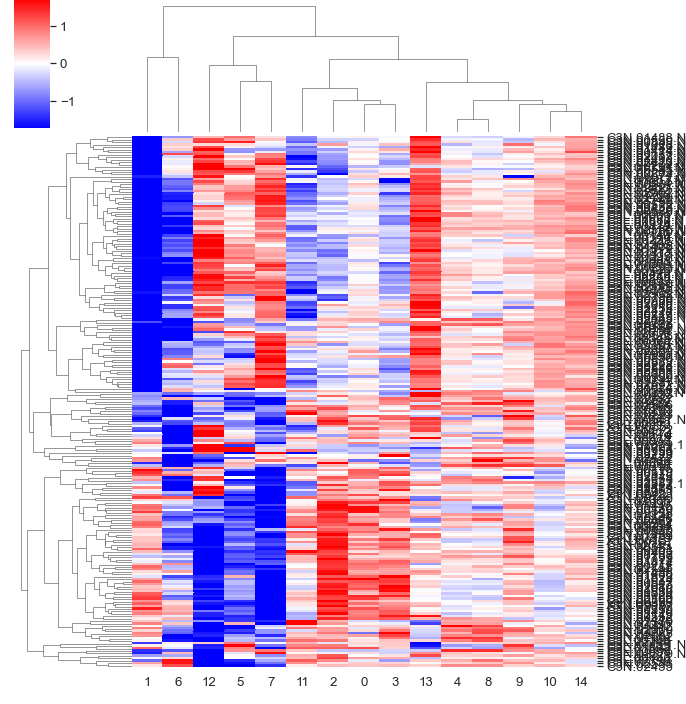

In [9]:
centers = centers.set_index(["Patient_ID"])
plotClustergram(centers, "", lim=max(np.max(np.abs(centers)) * 0.5), figsize=(10, 10), yticklabels=True)
centers = centers.reset_index()
# plt.savefig("CPTAC_GMM.svg", bbox_inches='tight', format='svg', dpi=1200)

## PCA Analysis

In [10]:
from msresist.figures.figureM1 import TumorType

centers = TumorType(centers)
c = 2

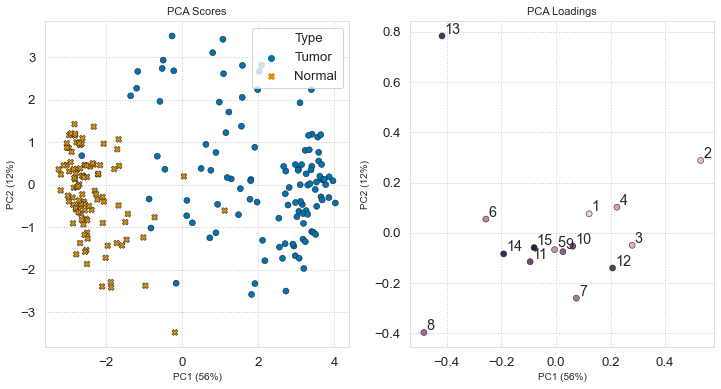

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
plotPCA(ax, centers, c, ["Patient_ID", "Type"], "Cluster", hue_scores="Type", style_scores="Type", hue_load="Cluster")

## Overview of Clustering Results

### Averages

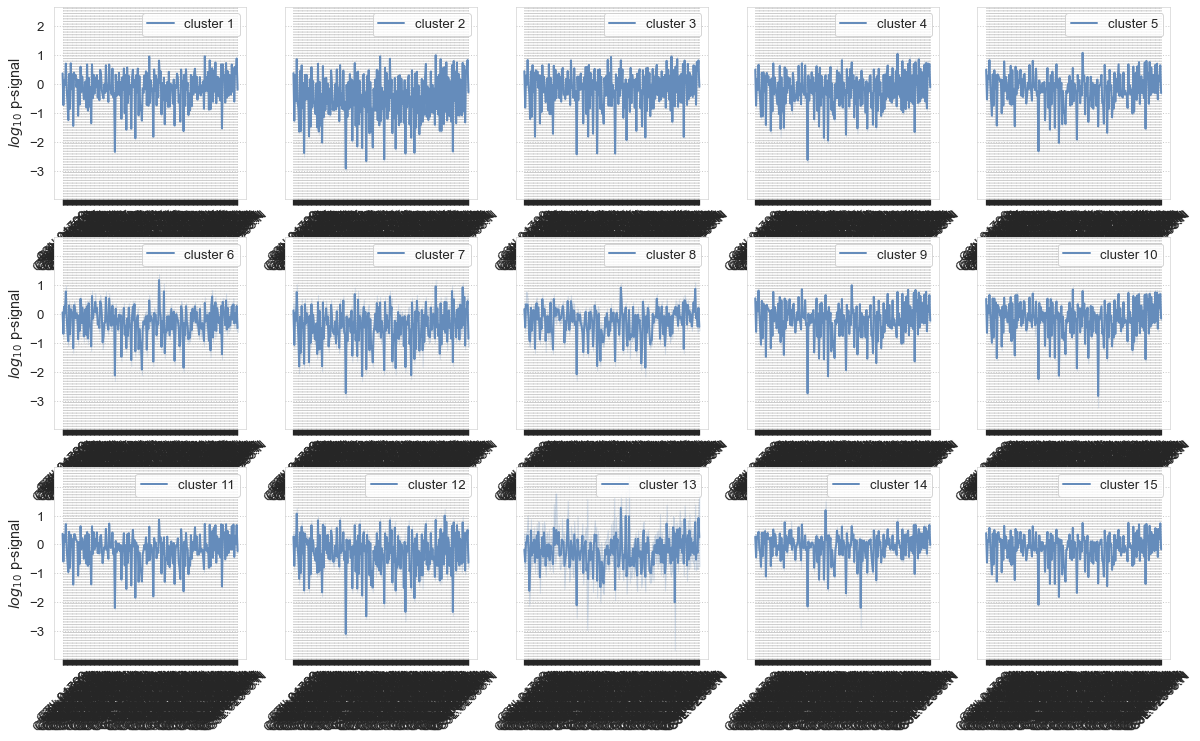

In [13]:
_, ax = plt.subplots(nrows=3, ncols=5, sharex=False, sharey=True, figsize=(20, 12))
plotClusters(ax, X_f.copy(), MSC.labels_ + 1, 5, centers.iloc[:, 0], figsize=(15, 15))

### Motifs

## Regression against Malignancy Status

In [23]:
for i in range(15):
    print(len(MSC.cl_seqs_[i]))

5702
2111
1861
932
2179
246
258
167
2072
628
2105
448
21
281
6255


In [40]:
from msresist.FileExporter import create_download_link

create_download_link(MSC.clustermembers(X_f.T), "clusters_CPTAC")